<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
《<a href="http://mng.bz/orYv">从零开始构建大型语言模型</a>》一书的补充代码，作者：<a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>代码仓库：<a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第5章：在无标签数据上进行预训练

In [122]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.5
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.7.1
tensorflow version: 2.19.0


- 在本章中，我们实现训练循环和基本模型评估代码来预训练LLM
- 在本章末尾，我们还将OpenAI的公开可用预训练权重加载到我们的模型中

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp" width=500px>

- 本章涵盖的主题如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=400px>

## 5.1 评估生成式文本模型

- 我们从简要回顾使用前一章代码初始化GPT模型开始本节
- 然后，我们讨论LLM的基本评估指标
- 最后，在本节中，我们将这些评估指标应用于训练和验证数据集

### 5.1.1 使用GPT生成文本

- 我们使用前一章的代码初始化一个GPT模型

In [123]:
import torch
from previous_chapters import GPTModel
# 如果本地没有 `previous_chapters.py` 文件，
# 你可以从 `llms-from-scratch` PyPI 包中导入。
# 详情请见：https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 例如：
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小
    "context_length": 256, # 缩短的上下文长度（原始：1024）
    "emb_dim": 768,        # 嵌入维度
    "n_heads": 12,         # 注意力头数
    "n_layers": 12,        # 层数
    "drop_rate": 0.1,      # Dropout率
    "qkv_bias": False      # 查询-键-值偏置
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 在推理期间禁用dropout

- 我们在上面使用了0.1的dropout，但现在训练LLM时不使用dropout是相对常见的
- 现代LLM也不在查询、键和值矩阵的`nn.Linear`层中使用偏置向量（与早期的GPT模型不同），这通过设置`"qkv_bias": False`来实现
- 我们将上下文长度（`context_length`）减少到仅256个token，以减少训练模型的计算资源需求，而原始的1.24亿参数GPT-2模型使用1024个token
  - 这样做是为了让更多读者能够在笔记本电脑上跟随和执行代码示例
  - 但是，请随意将`context_length`增加到1024个token（这不需要任何代码更改）
  - 我们稍后也会从预训练权重加载一个具有1024`context_length`的模型

- 接下来，我们使用前一章的`generate_text_simple`函数来生成文本
- 此外，我们定义两个便利函数，`text_to_token_ids`和`token_ids_to_text`，用于在token和文本表示之间转换，我们在本章中会使用这些函数

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=500px>

In [124]:
import tiktoken
from previous_chapters import generate_text_simple

# 或者：
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 添加批次维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 移除批次维度
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 如上所示，模型没有产生好的文本，因为它还没有被训练
- 我们如何以数字形式测量或捕获什么是"好文本"，以便在训练期间跟踪它？
- 下一小节介绍了计算生成输出损失指标的指标，我们可以用它来测量训练进度
- 关于微调LLM的下一章也将介绍测量模型质量的其他方法

<br>

### 5.1.2 计算文本生成损失：交叉熵和困惑度

- 假设我们有一个包含2个训练示例（行）的token ID的`inputs`张量
- 对应于`inputs`，`targets`包含我们希望模型生成的期望token ID
- 注意`targets`是`inputs`向右移动1个位置，正如我们在第2章实现数据加载器时所解释的

In [125]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将`inputs`输入到模型中，我们获得由3个token组成的2个输入示例的logits向量
- 每个token都是一个50,257维的向量，对应于词汇表的大小
- 应用softmax函数，我们可以将logits张量转换为包含概率分数的相同维度张量

In [126]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # 词汇表中每个token的概率
print(probas.shape) # 形状：(batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 下图使用一个非常小的词汇表进行说明，概述了我们如何将概率分数转换回文本，这是我们在前一章末尾讨论的

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=500px>

- 如前一章所讨论的，我们可以应用`argmax`函数将概率分数转换为预测的token ID
- 上面的softmax函数为每个token产生了一个50,257维的向量；`argmax`函数返回该向量中最高概率分数的位置，这是给定token的预测token ID

- 由于我们有2个输入批次，每个批次有3个token，我们得到2×3的预测token ID：

In [127]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们解码这些token，我们发现它们与我们希望模型预测的token（即目标token）相当不同：

In [128]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型还没有被训练
- 为了训练模型，我们需要知道它与正确预测（目标）的距离有多远

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

- 对应于目标索引的token概率如下：

In [129]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化所有这些值，使它们接近概率1
- 在数学优化中，最大化概率分数的对数比最大化概率分数本身更容易；这超出了本书的范围，但我在这里录制了一个包含更多细节的讲座：[L8.2 逻辑回归损失函数](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [130]:
# 计算所有token概率的对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们计算平均对数概率：

In [131]:
# 计算每个token的平均概率
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是通过优化模型权重使这个平均对数概率尽可能大
- 由于对数的性质，最大可能值是0，我们目前距离0还很远

- 在深度学习中，不是最大化平均对数概率，而是标准惯例是最小化*负*平均对数概率值；在我们的情况下，不是最大化-10.7722使其接近0，在深度学习中，我们会最小化10.7722使其接近0
- -10.7722的负值，即10.7722，在深度学习中也称为交叉熵损失

In [132]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch已经实现了一个`cross_entropy`函数来执行前面的步骤

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=400px>

- 在应用`cross_entropy`函数之前，让我们检查logits和targets的形状

In [133]:
# Logits的形状为(batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets的形状为(batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于PyTorch中的`cross_entropy`函数，我们希望通过在批次维度上组合来展平这些张量：

In [134]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 注意targets是token ID，它们也代表我们想要最大化的logits张量中的索引位置
- PyTorch中的`cross_entropy`函数将自动处理在要最大化的logits中那些token索引上应用softmax和对数概率计算

In [135]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 与交叉熵损失相关的一个概念是LLM的困惑度
- 困惑度简单地是交叉熵损失的指数

In [136]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更具可解释性，因为它可以理解为模型在每一步不确定的有效词汇表大小（在上面的例子中，那将是48,725个单词或token）
- 换句话说，困惑度提供了一个衡量模型预测的概率分布与数据集中单词的实际分布匹配程度的指标
- 与损失类似，较低的困惑度表明模型预测更接近实际分布

### 5.1.3 计算训练和验证集损失

- 我们使用一个相对较小的数据集来训练LLM（实际上只有一个短篇小说）
- 原因是：
  - 你可以在没有合适GPU的笔记本电脑上在几分钟内运行代码示例
  - 训练完成相对较快（几分钟而不是几周），这对教育目的很好
  - 我们使用公共领域的文本，可以包含在这个GitHub仓库中而不违反任何使用权利或使仓库大小膨胀


- 例如，Llama 2 7B需要在A100 GPU上训练184,320个GPU小时，处理2万亿个token
  - 在撰写本文时，AWS上8xA100云服务器的每小时成本约为\\$30
  - 因此，通过粗略计算，训练这个LLM的成本为184,320 / 8 * \\$30 = \\$690,000
 
- 下面，我们使用第2章中使用的相同数据集

In [137]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 通过打印前99个和后99个字符来快速检查文本是否正确加载

In [138]:
# 前99个字符
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [139]:
# 后99个字符
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [140]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 有5,145个token，这个文本对于训练LLM来说非常短，但同样，这是为了教育目的（我们稍后也会加载预训练权重）

- 接下来，我们将数据集分为训练集和验证集，并使用第2章的数据加载器来为LLM训练准备批次
- 为了可视化目的，下图假设`max_length=6`，但对于训练加载器，我们将`max_length`设置为LLM支持的上下文长度
- 下图为了简单起见只显示输入token
    - 由于我们训练LLM预测文本中的下一个单词，目标看起来与这些输入相同，除了目标向右移动一个位置

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [141]:
from previous_chapters import create_dataloader_v1
# 或者：
# from llms_from_scratch.ch02 import create_dataloader_v1

# 训练/验证比例
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [142]:
# 健全性检查

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("训练加载器的token不足。"
          "尝试降低`GPT_CONFIG_124M['context_length']`或"
          "增加`training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("验证加载器的token不足。"
          "尝试降低`GPT_CONFIG_124M['context_length']`或"
          "减少`training_ratio`")

- 我们使用相对较小的批次大小来减少计算资源需求，也因为数据集本身就很小
- 例如，Llama 2 7B使用1024的批次大小进行训练

- 可选检查数据是否正确加载：

In [143]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选检查，确认token大小在预期范围内：

In [144]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们实现一个实用函数来计算给定批次的交叉熵损失
- 此外，我们实现第二个实用函数来计算数据加载器中用户指定数量批次的损失

In [145]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果num_batches超过数据加载器中的批次数量，
        # 则减少批次数量以匹配数据加载器中的总批次数
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果你有一台支持CUDA的GPU机器，LLM将在GPU上训练，无需对代码进行任何更改
- 通过`device`设置，我们确保数据加载到与LLM模型相同的设备上

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 注意：
# 取消注释以下行将允许代码在Apple Silicon芯片上运行（如果适用），
# 这比在Apple CPU上快约2倍（在M3 MacBook Air上测量）。
# 但是，结果损失值可能略有不同。

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # 对于nn.Module类，不需要赋值model = model.to(device)


torch.manual_seed(123) # 由于数据加载器中的洗牌，为了可重现性

with torch.no_grad(): # 禁用梯度跟踪以提高效率，因为我们还没有训练
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.981106758117676


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=400px>

## 5.2 训练LLM

- 在本节中，我们最终实现了训练LLM的代码
- 我们专注于一个简单的训练函数（如果你有兴趣用更高级的技术来增强这个训练函数，如学习率预热、余弦退火和梯度裁剪，请参考[附录D](../../appendix-D/01_main-chapter-code)）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=300px>

In [147]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 初始化列表来跟踪损失和已见token
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 主训练循环
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 重置前一批次迭代的损失梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 计算损失梯度
            optimizer.step() # 使用损失梯度更新模型权重
            tokens_seen += input_batch.numel()
            global_step += 1

            # 可选的评估步骤
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每个epoch后打印一个样本文本
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # 紧凑打印格式
    model.train()

- 现在，让我们使用上面定义的训练函数来训练LLM：

In [148]:
# 注意：
# 取消注释以下代码来计算执行时间
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# 注意：
# 取消注释以下代码来显示执行时间
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

- 注意你在你的计算机上可能会得到略微不同的损失值，如果它们大致相似（训练损失低于1，验证损失低于7），这不是令人担心的原因
- 小的差异通常可能是由于不同的GPU硬件和CUDA版本或较新PyTorch版本中的小变化
- 即使你在CPU上运行示例，你也可能观察到轻微的差异；差异的一个可能原因是`nn.Dropout`在不同操作系统上的不同行为，这取决于PyTorch的编译方式，如[PyTorch问题跟踪器上的讨论](https://github.com/pytorch/pytorch/issues/121595)

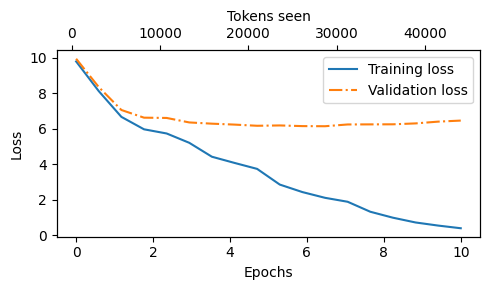

In [149]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 从上面的结果可以看出，模型开始时生成不可理解的单词串，而到最后，它能够产生语法上或多或少正确的句子
- 然而，基于训练和验证集损失，我们可以看到模型开始过拟合
- 如果我们检查它在最后写的一些段落，我们会发现它们逐字包含在训练集中——它只是记忆了训练数据
- 稍后，我们将介绍可以在一定程度上缓解这种记忆的解码策略
- 注意这里的过拟合发生是因为我们有一个非常非常小的训练集，并且我们多次迭代它
  - 这里的LLM训练主要用于教育目的；我们主要想看到模型可以学会产生连贯的文本
  - 我们不是花费数周或数月在大量昂贵硬件上训练这个模型，而是稍后加载预训练权重

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=350px>

**如果你有兴趣用更高级的技术来增强这个训练函数，如学习率预热、余弦退火和梯度裁剪，请参考[附录D](../../appendix-D/01_main-chapter-code)**

**如果你对更大的训练数据集和更长的训练运行感兴趣，请参见[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 控制随机性的解码策略

- 对于像我们上面训练的GPT模型这样相对较小的LLM，推理相对便宜，所以如果你在上面使用GPU进行训练，就不需要使用GPU进行推理
- 使用我们之前在简单训练函数内部使用的`generate_text_simple`函数（来自前一章），我们可以一次生成一个单词（或token）的新文本
- 如5.1.2节所解释的，下一个生成的token是对应于词汇表中所有token中最大概率分数的token

In [150]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


- 即使我们多次执行上面的`generate_text_simple`函数，LLM也总是生成相同的输出
- 我们现在介绍两个概念，即所谓的解码策略，来修改`generate_text_simple`：*温度缩放*和*top-k*采样
- 这些将允许模型控制生成文本的随机性和多样性

### 5.3.1 温度缩放

- 之前，我们总是使用`torch.argmax`采样具有最高概率的token作为下一个token
- 为了增加多样性，我们可以使用`torch.multinomial(probs, num_samples=1)`来采样下一个token，从概率分布中采样
- 在这里，每个索引被选中的机会对应于它在输入张量中的概率

- 这里是生成下一个token的小回顾，假设一个非常小的词汇表用于说明目的：

In [151]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# 假设输入是"every effort moves you"，LLM
# 为下一个token返回以下logits：
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 下一个生成的token如下：
print(inverse_vocab[next_token_id])

forward


In [152]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


- 我们不是通过`torch.argmax`确定最可能的token，而是使用`torch.multinomial(probas, num_samples=1)`通过从softmax分布中采样来确定最可能的token
- 为了说明目的，让我们看看当我们使用原始softmax概率采样下一个token 1,000次时会发生什么：

In [153]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # 为了可重现性设置手动种子
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 我们可以通过一个叫做温度缩放的概念来控制分布和选择过程
- "温度缩放"只是将logits除以一个大于0的数字的花哨说法
- 大于1的温度在应用softmax后会导致更均匀分布的token概率
- 小于1的温度在应用softmax后会导致更自信（更尖锐或更峰值）的分布

- 注意结果的dropout输出可能因您的操作系统而异；您可以在[PyTorch问题跟踪器上](https://github.com/pytorch/pytorch/issues/121595)阅读更多关于这种不一致性的信息

In [154]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# 温度值
temperatures = [1, 0.1, 5]  # 原始、更高置信度和更低置信度

# 计算缩放概率
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

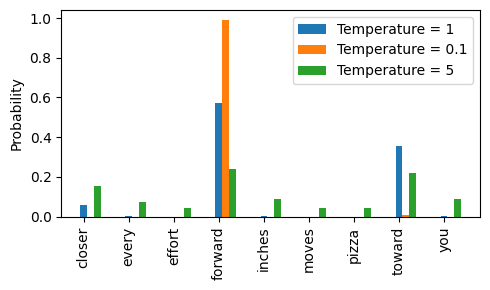

In [155]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 我们可以看到通过温度0.1的重新缩放导致了更尖锐的分布，接近`torch.argmax`，使得最可能的单词几乎总是被选中：

In [35]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 通过温度5重新缩放的概率分布更加均匀：

In [157]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 假设LLM输入"every effort moves you"，使用上述方法有时会产生无意义的文本，如"every effort moves you pizza"，在3.2%的时间内（1000次中的32次）

### 5.3.2 Top-k采样

- 另一种流行的方法是所谓的top-k采样，我们将概率质量限制在最可能的k个token上
- 然后，我们重新分配概率质量，使这k个token的概率总和为1

- 为了能够使用更高的温度来增加输出多样性并减少无意义句子的概率，我们可以将采样的token限制在最可能的top-k个token上：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=500px>

- （请注意，此图中的数字被截断为小数点后两位以减少视觉混乱。Softmax行中的值应该加起来等于1.0。）

- 在代码中，我们可以如下实现：

In [156]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [158]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> 注意：  
>
>  前一个代码单元的另一种稍微更高效的实现如下：
>
> ```python
> new_logits = torch.full_like( # 创建包含-inf值的张量
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # 将top k值复制到-inf张量中
> ```
> <br>
> 更多详情，请参见 https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [159]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 修改文本生成函数

- 前面两个小节介绍了温度采样和top-k采样
- 让我们使用这两个概念来修改我们之前用于通过LLM生成文本的`generate_simple`函数，创建一个新的`generate`函数：

In [161]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For循环与之前相同：获取logits，只关注最后一个时间步
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 新增：使用top_k采样过滤logits
        if top_k is not None:
            # 只保留top_k值
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 新增：应用温度缩放
        if temperature > 0.0:
            logits = logits / temperature

            # 应用softmax获得概率
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 从分布中采样
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 否则与之前相同：获取具有最高logits值的词汇表条目的idx
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # 如果遇到序列结束token且指定了eos_id，则提前停止生成
            break

        # 与之前相同：将采样的索引附加到运行序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [162]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


## 5.4 在PyTorch中加载和保存模型权重

- 训练LLM在计算上是昂贵的，因此能够保存和加载LLM权重至关重要

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-3.webp" width=400px>

- PyTorch中推荐的方法是通过对`.state_dict()`方法应用`torch.save`函数来保存模型权重，即所谓的`state_dict`：

In [166]:
torch.save(model.state_dict(), "model.pth")

- 然后我们可以将模型权重加载到新的`GPTModel`模型实例中，如下所示：

In [167]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

- 通常使用自适应优化器如Adam或AdamW而不是常规SGD来训练LLM
- 这些自适应优化器为每个模型权重存储额外的参数，因此如果我们计划稍后继续预训练，保存它们也是有意义的：

In [168]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [169]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 从OpenAI加载预训练权重

- 之前，我们只是为了教育目的使用一本非常小的短篇小说书训练了一个小型GPT-2模型
- 感兴趣的读者也可以在[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)中找到在完整的古腾堡计划书籍语料库上的更长预训练运行
- 幸运的是，我们不必花费数万到数十万美元在大型预训练语料库上预训练模型，而是可以加载OpenAI提供的预训练权重

---

---


⚠️ **注意：由于TensorFlow兼容性问题，特别是在某些Windows系统上，一些用户可能在本节中遇到问题。这里只需要TensorFlow来加载原始的OpenAI GPT-2权重文件，然后我们将其转换为PyTorch。
如果您遇到TensorFlow相关问题，可以使用下面的替代代码而不是本节中的其余代码。
这个替代方案基于预转换的PyTorch权重，使用与前一节中描述的相同转换过程创建。详情请参考notebook：
[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb) notebook。**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 首先，一些样板代码来从OpenAI下载文件并将权重加载到Python中
- 由于OpenAI使用了[TensorFlow](https://www.tensorflow.org/)，我们将必须安装和使用TensorFlow来加载权重；[tqdm](https://github.com/tqdm/tqdm)是一个进度条库
- 取消注释并运行下一个单元格来安装所需的库

In [46]:
# pip install tensorflow tqdm

In [170]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [171]:
# 从此文件夹中包含的gpt_download.py进行相对导入

from gpt_download import download_and_load_gpt2
# 或者：
# from llms_from_scratch.ch05 import download_and_load_gpt2

---

**注意**

- 在极少数情况下，上面的代码单元格可能会导致`zsh: illegal hardware instruction python`错误，这可能是由于您机器上的TensorFlow安装问题
- 一位读者发现通过`conda`安装TensorFlow解决了这个特定情况下的问题，如[这里](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888)所述
- 您可以在这个补充的[Python设置教程](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda)中找到更多说明

---

- 然后我们可以如下下载1.24亿参数模型的模型权重：

In [172]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 76.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 824kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 90.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:11<00:00, 6.96MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 12.3MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 526kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 497kiB/s] 


In [173]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [51]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [52]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 或者，"355M"、"774M"和"1558M"也是支持的`model_size`参数
- 这些不同大小模型之间的差异在下图中总结：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-sizes.webp?timestamp=123" width=500px>

- 上面，我们将124M GPT-2模型权重加载到Python中，但是我们仍然需要将它们传输到我们的`GPTModel`实例中
- 首先，我们初始化一个新的GPTModel实例
- 注意原始GPT模型在多头注意力模块中为查询、键和值矩阵的线性层初始化了偏置向量，这不是必需的或推荐的；但是，为了能够正确加载权重，我们也必须通过在我们的实现中将`qkv_bias`设置为`True`来启用这些
- 我们还使用了原始GPT-2模型使用的`1024`token上下文长度

In [53]:
# 在字典中定义模型配置以保持紧凑
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 复制基础配置并使用特定模型设置更新
model_name = "gpt2-small (124M)"  # 示例模型名称
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 下一个任务是将OpenAI权重分配给我们`GPTModel`实例中相应的权重张量

In [54]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [55]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们可以使用之前的`generate`函数来生成新文本：

In [56]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




- 我们知道我们正确加载了模型权重，因为模型可以生成连贯的文本；如果我们犯了哪怕一个小错误，模型都无法做到这一点

- 有关从Hugging Face Hub加载权重的替代方法，请参见[../02_alternative_weight_loading](../02_alternative_weight_loading)
- 如果您有兴趣了解GPT架构与Llama架构（Meta AI开发的流行LLM）的比较，请参见[../07_gpt_to_llama](../07_gpt_to_llama)的奖励内容

## 总结和要点

- 请参见[./gpt_train.py](./gpt_train.py)脚本，这是一个用于训练的独立脚本
- [./gpt_generate.py](./gpt_generate.py)脚本从OpenAI加载预训练权重并基于提示生成文本
- 您可以在[./exercise-solutions.ipynb](./exercise-solutions.ipynb)中找到练习解答